In [1]:
import numpy as np
import pandas as pd
from glob import glob
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
# from pandarallel import pandarallel
import matplotlib.dates as mdates
import time
# pandarallel.initialize()
import datetime

In [2]:
plt.style.use('./MNRAS_stylesheet')

In [195]:
#######################################
###                                 ###
###   STEP 1: Read and clean data   ###
###                                 ###
#######################################

class datacleaner():
    def __init__(self):
        tstart=time.time()
        # Get list of all files
        flist = glob('./MSFT/*csv')
        # Parallel read the files
        dfs= Parallel(n_jobs=8)(delayed(pd.read_csv)(i) for i in flist)
        print("Lengths",[len(w) for w in dfs])
        total_length1 = np.sum([len(w) for w in dfs])
        print(np.round(time.time()-tstart,2),"Read data")
        # Select only exchange "Q"
        dfs= Parallel(n_jobs=8)(delayed(self.select_exchange)(i) for i in dfs)
        print(np.round(time.time()-tstart,2),"Selected on exchange")
        total_length2 = np.sum([len(w) for w in dfs])
        # Drop corrected
        dfs= Parallel(n_jobs=8)(delayed(self.drop_corr)(i) for i in dfs)
        print(np.round(time.time()-tstart,2),"Dropped corrected")
        total_length3 = np.sum([len(w) for w in dfs])
        #pd.concat(dfs).to_pickle('MSFT_2015_2020_highres.pickle')
        # Aggregate to second level(otherwise things are way too slow)
        dfs= Parallel(n_jobs=8)(delayed(self.to_seconds)(i) for i in dfs)
        print(np.round(time.time()-tstart,2),"Made seconds from millisecond data")
        total_length4 = np.sum([len(w) for w in dfs])
        # Group by datetime (sum of sizes and median of prices)
        dfs= Parallel(n_jobs=8)(delayed(self.aggregate)(i) for i in dfs)
        print(np.round(time.time()-tstart,2),"Grouped by datetime")
        total_length5 = np.sum([len(w) for w in dfs])
        # Remove low outliers
        #dfs= Parallel(n_jobs=8)(delayed(self.neg_outlier)(i) for i in dfs)
        #print(np.round(time.time()-tstart,2),"Removed low outliers")
        # Get datetime and drop unknowns
        dfs= Parallel(n_jobs=8)(delayed(self.clean)(i) for i in dfs)
        print(np.round(time.time()-tstart,2),"Converted to datetimes")
        total_length6 = np.sum([len(w) for w in dfs])

        # Concatenate them vertically
        self.df = pd.concat(dfs)        
        # Sort them
        self.sort()
        # Get hourly dataframe        
        self.get_hourly()
        # Write to files
        self.write()
        print(np.round(time.time()-tstart,2), "Done")
        print(total_length1, total_length2, total_length3, 
              total_length4, total_length5, total_length6)
        
        
    def to_seconds(self,df):
        df['time_sec'] = df.TIME_M.apply(lambda x: x.split('.')[0])
        return df
    
    def select_exchange(self,df):
        return df[df.EX=='Q']
        
    def clean(self,df):
        # Remove 9999.999 values
        df = df.drop(df[df.PRICE>5000].index)
        df = df.reset_index()
        df['DATETIME'] = df['DATE'].astype(str) + ' ' + df['time_sec']
        df['DATETIME'] = pd.to_datetime(df['DATETIME'])
        return df
        
        
    def neg_outlier(self,df):
        # rolling window to remove outliers at 60std
        prices = df.PRICE
        r = prices.rolling(window=4000)  # Create a rolling object 
        mps = r.mean() - 60. * r.std()  # Combine a mean and stdev on that object
        outliers = prices[prices < mps].index
        df = df.drop(outliers)
        return df
        
    def drop_corr(self,df):
        # Drop all items that are corrected (see Barndorff-Nielsen)
        df = df[df.TR_CORR==0]
        return df
        
        
    def aggregate(self,df):
        # Groupby datetime (e.g. two ticks at same moment become one)
        df = pd.DataFrame({'SIZE':df.groupby(['DATE','time_sec']).SIZE.sum(),
                           'PRICE':df.groupby(['DATE','time_sec']).PRICE.median()})
        return df
        
    def sort(self):
        self.df = self.df[['SIZE','PRICE','DATETIME']].set_index('DATETIME')
        self.df = self.df.sort_index()
        
    def get_hourly(self):
        # Aggregate to hourly dateframe, just for visualization
        self.hourly=self.df.reset_index().resample('H', on='DATETIME').median()
        
    def write(self):
        # Write to pickle files
        self.df.to_pickle('MSFT_2015_2020.pickle')
        self.hourly.to_pickle('MSFT_hourly.pickle')
    
    def get_df(self):
        return self.df
        
reader = datacleaner()
df = reader.get_df()

KeyboardInterrupt: 

In [3]:
# Read in pickle file
df = pd.read_pickle('MSFT_2015_2020.pickle')

In [4]:
# Highres df (either all (Luuk) or COVID period
df_highres = pd.read_pickle('MSFT_2015_2020_highres.pickle')
df_highres_covid = pd.read_pickle('COVID_highres.pickle')

In [5]:
# Read in splitted files
df = pd.concat([pd.read_pickle(w) for w in ['df.part1.pickle','df.part2.pickle','df.part3.pickle']])

In [7]:
corona_peak = df.loc['2020-03-16']

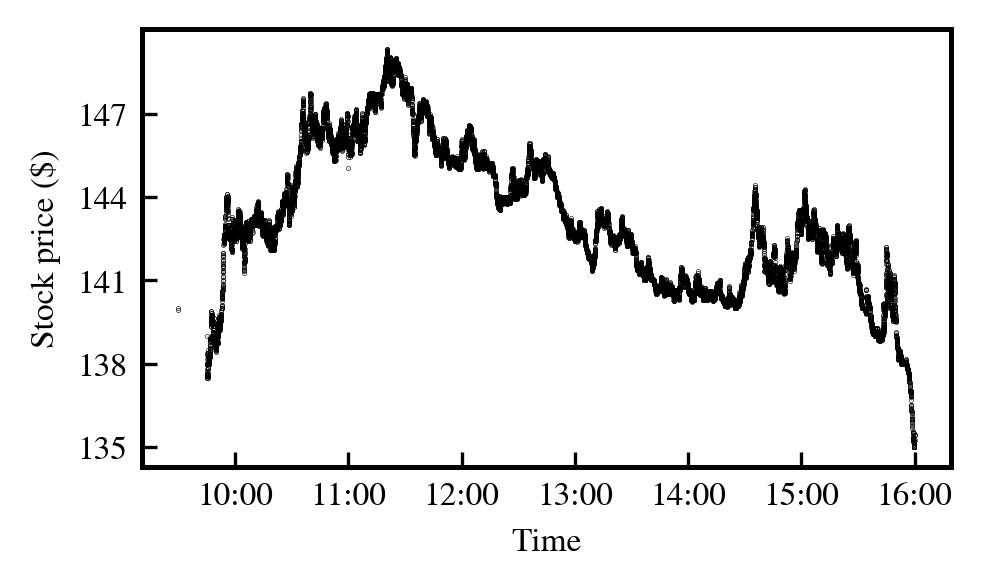

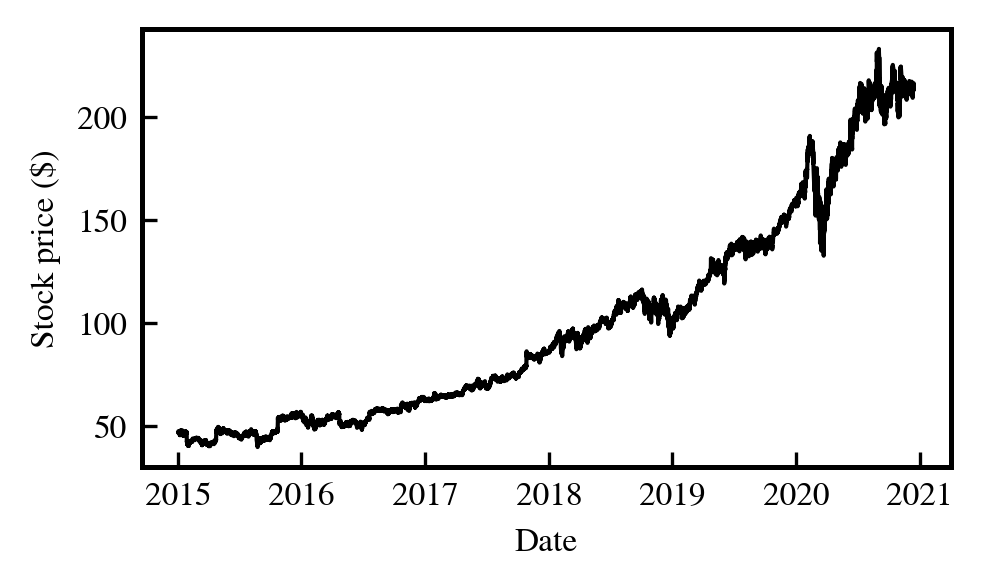

In [8]:
def plot_one_day():
    plt.figure(figsize=(3.321,2))
    plt.scatter(corona_peak.index, corona_peak.PRICE,s=0.02,color='black')
    
    xformatter = mdates.DateFormatter('%H:%M')
    plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
    plt.xlabel('Time')
    plt.yticks(np.arange(135,149,3))
    plt.ylabel('Stock price ($)')
    plt.tight_layout()
    plt.savefig('MSFT_intraday.pdf')
    
    plt.show()
def plot_all():
    plt.figure(figsize=(3.321,2))
    plt.plot(df.index, df.PRICE,color='black',lw=1)
    
    plt.xlabel('Date')
    plt.ylabel('Stock price ($)')
    plt.tight_layout()
    plt.savefig('MSFT_6years.pdf')
    plt.show()
plot_one_day()
plot_all()

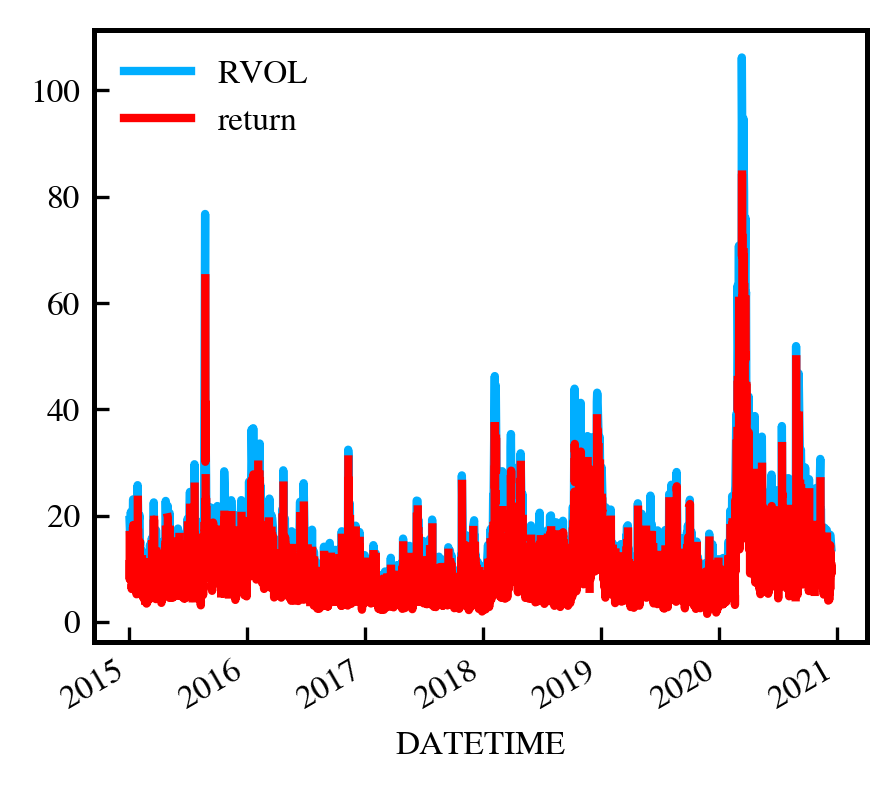

In [10]:
from scipy.stats import norm
class realized_variance():
    def __init__(self):
#         self.df = pd.read_pickle('MSFT_2015_2020.pickle')
        self.df = df
        self.df = self.df[['PRICE']].resample("5T").median() 
        self.to_returns()
        self.RV()
        self.__RVOL__()
        self.plot()
        return
    
    def to_returns(self):
        self.logprice = np.log(self.df[['PRICE']])
        self.returns  = (self.logprice.diff()*100).iloc[1:]
        
    def get_df(self):
        return self.returns
    
    def RV(self):
        values = self.returns#.iloc[:10000]
        values.columns = ['return']
        """values['day'] = pd.Series(values.index).apply(lambda x: pd.to_datetime(x.strftime("%Y-%m-%d"))).values
        kernel_mu  = self.returns.resample("1D").mean()
        kernel_mu.columns = ['mean']
        kernel_std = self.returns.resample("1D").std()
        kernel_std.columns = ['std']
        values = pd.merge(values,kernel_mu, left_on='day',right_index=True)
        values = pd.merge(values,kernel_std, left_on='day',right_index=True)
        
        weights = norm(values['mean'], values['std']).pdf(values['return'])"""
        weighted_return = values['return']**2 #*weights
        self.RV = weighted_return.resample("1D").sum()
        self.RV = self.RV[(self.RV != 0)]
        
    def __RVOL__(self):
        self.RVOL = np.sqrt(self.RV)
        self.RVOL = self.RVOL*np.sqrt(252)
        
    def plot(self):
        fig,ax = plt.subplots()
        ax.plot(self.RVOL,label='RVOL')
        (self.returns*100).rolling(40).std().plot(color='red',ax=ax,label='Rolling std')
        plt.legend()
        plt.show()

relvar = realized_variance()
retdf=relvar.get_df()
RVOL = relvar.RVOL

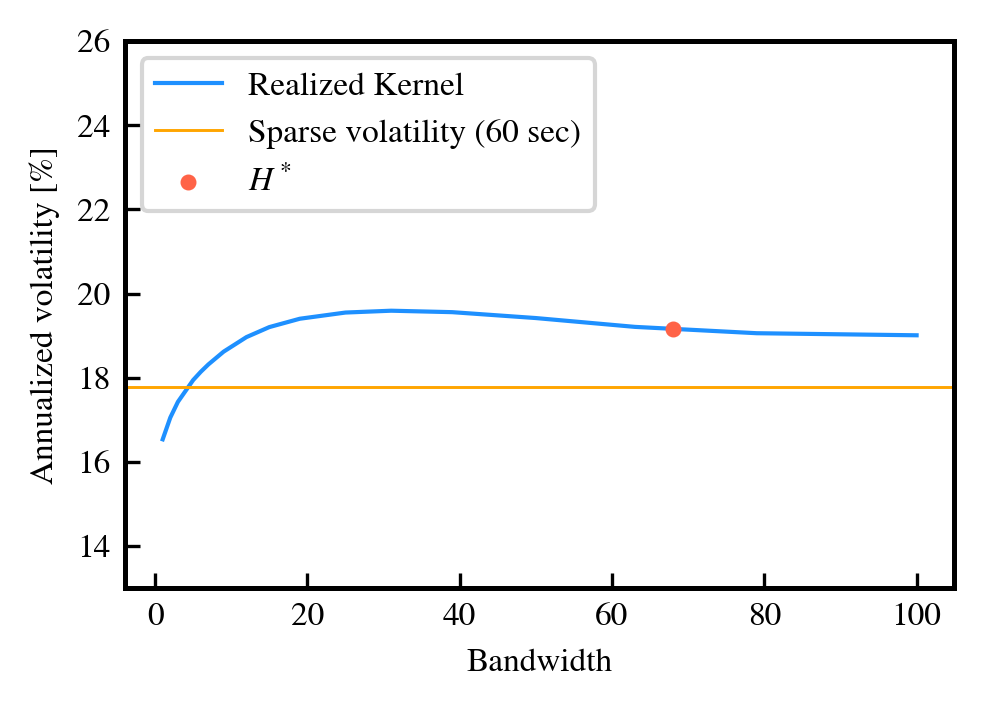

In [6]:
class realized_kernel():
    def __init__(self):
        """Initialize, call some functions"""
        self.make_time_index()
        return

    def make_time_index(self):
        """We want the data to be restructured onto a regular 1 sec grid 
           to obtain the sparse estimates. Therefore we built a list of 1sec
           times"""
        # Define time arr for every second
        times = []
        for hours in range(9,16):
            for minutes in range(0,60):
                for seconds in np.arange(0,60,1):
                    h = str(hours) if hours>=10 else '0'+str(hours)
                    m = str(minutes) if minutes>=10 else '0'+str(minutes)
                    s = str(seconds) if seconds>=10 else '0'+str(seconds)
                    times.append(h+':'+m+':'+s)
        #times = times[60:]
        self.times = times[1800:]
        
    def make_regular_df(self,df):
        """Make 1 sec regular dataframe from irregular one day dataframe of prices.
           Note, irregular_day_df should be a 1-day only dataframe with prices
           (no sizes here). If there is no trade, we take the previous time"""
        # Extract times from datetimes
        df['time'] = pd.Series(df.index.values).apply(lambda x: x.strftime('%H:%M:%S')).values
        # Make time indes
        df= df.set_index('time')
        # Save irregular spaced dataframe
        irregular_df = df.copy()
        # Get data for all datetimes, where we fill forward if there is no data
        df = df.reindex(self.times).fillna(method='ffill')
        
        df['logprice'] = np.log(df.PRICE)
        # Get deltalog and deltalog^2 prices
        df['deltalog'] = df.logprice.diff()*100
        df['deltalog2'] = (df['deltalog'])**2
        
        irregular_df['logprice'] = np.log(irregular_df.PRICE)
        # Get deltalog and deltalog^2 prices
        irregular_df['deltalog'] = irregular_df.logprice.diff()*100
        irregular_df['deltalog2'] = (irregular_df['deltalog'])**2
        return df, irregular_df
    
    def make_sparse_df(self,df):
        """Make 1 minute interpolated dataframe"""
        # Get median price for each minute
        sparse_df = df[['PRICE']].resample('1T').median()
        # Get log price
        sparse_df['logprice'] = np.log(sparse_df.PRICE)
        # Get deltalog and deltalog^2 prices
        sparse_df['deltalog'] = sparse_df.logprice.diff()*100
        sparse_df['deltalog2'] = (sparse_df['deltalog'])**2
        # drop na's from initial return, as we have no data there (ie no overnight)
        sparse_df = sparse_df.dropna()
        return sparse_df
    
    def get_RV_sparse(self,input_logprices):
        """Obtain estimate for RVsparse using the 1-sec interpolated logprices"""
        offsets = np.arange(1200)
        RVs =  np.zeros(1200) # 20min sets
        for offset in offsets:
            # built array (ie 0,1200,2400, etc)
            tochoose = np.arange(0+offset,len(input_logprices),1200)
            # select each 1200th element (plus offset)
            logprices = input_logprices.iloc[tochoose].values.flatten()
            diffs = np.diff(logprices)*100
            RV = np.sum(diffs**2)
            RVs[offset] = RV
        return np.mean(RVs)
    
    
    def RV_dense(self,input_logprices):
        """Get estimate for the dense RV using all irregular spaced returns"""
        q = 25
        offsets = np.arange(q)
        RVs = np.zeros(q)
        Ns  = np.zeros(q)
        for offset in offsets:
            tochoose = np.arange(0+offset,len(input_logprices),q)
            logprices = input_logprices.iloc[tochoose].values.flatten()
            diffs = np.diff(logprices)*100
            RV = np.sum(diffs**2)
            RVs[offset] = RV
            Ns[offset]  = (diffs>0).sum()
        return RVs,Ns
    
    def get_omega(self,df_irregular):
        """Get estimate for omega^2 hat"""
        # collect RVdense estimates
        RVdenses,Ns = self.RV_dense(df_irregular[['logprice']])
        omega2hat_i = RVdenses / (2*Ns)
        omega2hat = np.mean(omega2hat_i)
        return omega2hat
    
    
    def get_optimal_bandwidth(self,regular_df,irregular_df):
        # get estimate for sparse RV
        rvsparse = self.get_RV_sparse(regular_df[['logprice']])
        # Get omega
        omega2hat = self.get_omega(irregular_df)
        xi2 = omega2hat / rvsparse
        xi = np.sqrt(xi2)
        H =  int(3.5134*len(irregular_df)**(3/5)*xi**(4/5))
        return H
    
    
    def Parzen(self,x):
        """Return Parzen kernel for x"""
        if 0<=np.abs(x)<=1/2:
            return 1-6*np.abs(x)**2+6*np.abs(x)**3
        elif 1/2<=np.abs(x)<=1:
            return 2*(1-np.abs(x))**3
        elif np.abs(x)>1:
            return 0
        
    def obtain_K(self,H,irregular_df):
        # make array to loop from -H to H
        h_arr = np.arange(-H,H+1,1,dtype=int)
        # make flat numpy array from the raw return data (approx second)
        x = irregular_df.deltalog.dropna().values.flatten()
        K_X = 0
        parzen_values=[]
        # loop 1 over the lags
        gammas = []
        for h in h_arr:
            j_arr = np.arange(np.abs(h)+1,len(x)+1,dtype=int)
            gamma_h = 0
            # loop two for the autocovariances
            for j in j_arr:
                gamma_h += x[j-1]*x[j-np.abs(h)-1]
            K_X += gamma_h*self.Parzen(h/(H+1))
        return np.sqrt(252*K_X)
    
    def worker(self,day,H=None,get_H=False):
        """worker to loop over days"""
        try:
            daily_counts = pd.read_hdf('./days.h5')
            counts = daily_counts.loc[day].iloc[0]
            # to be faster: find where we are approximately
            iloc0 = max(int(daily_counts.loc[:day].sum().iloc[0]-counts)-1000,0)
            hdf_df = pd.read_hdf('./data.h5')
            oneday = hdf_df.iloc[iloc0:counts+iloc0+1000].loc[day]
            # get regular and irregular dfs
            regular_df, irregular_df = self.make_regular_df(oneday)
            # make sparse (1min) df
            sprse_oneday = self.make_sparse_df(oneday)
            # get RVsparse
            RVsparse = self.get_RV_sparse(regular_df[['logprice']])
            # get optimal bandwidth
            Hopt = self.get_optimal_bandwidth(regular_df, irregular_df)
            # get realized kernel estimate 
            if not H:
                H = Hopt
            else:
                H = H
            RK_est = self.obtain_K(H,irregular_df)
            print(day,'success')
            if get_H:
                return RK_est,H
            else:
                return RK_est
        except:
            print(day,'failed')
            return np.nan
    def iterate_over_days(self):
        # Get unique days in dataset
        days = df.resample('1D').median()
        days = days.dropna().index
        days = pd.Series(days).apply(lambda x: x.strftime('%Y-%m-%d')).values
        daily_counts = df[['PRICE']].resample('1D').count()
        # Write to hdf5 file to parallel read them
        df.to_hdf('data.h5', key='df', mode='w')
        daily_counts.to_hdf('days.h5', key='df', mode='w')
        # iterate over days
        RK_estimates = Parallel(n_jobs=23)(delayed(self.worker)(i) for i in days)
        #np.array([self.worker(day) for day in days[:N]])#
        self.RKvalues = pd.DataFrame({'Day':days,'RealizedKernel':RK_estimates})
        return self.RKvalues

    def signature_plot(self):
        Hs = np.hstack((np.logspace(0.1,2.,20,dtype=int),None))
        K_Hs = Parallel(n_jobs=23)(delayed(self.worker)('2015-01-02',H,True) for H in Hs)
        Ks = np.array([w[0] for w in K_Hs])
        plt.figure(figsize=(3.321,2.4))
        plt.ylabel('Annualized volatility [%]')

        plt.plot(Hs,Ks,color='dodgerblue',label='Realized Kernel',lw=1,zorder=1)
        #plt.scatter(H_opt,obtain_K(H_opt),color='red',s=2)
        
        day = '2015-01-02'
        daily_counts = pd.read_hdf('./days.h5')
        counts = daily_counts.loc[day].iloc[0]
        # to be faster: find where we are approximately
        iloc0 = max(int(daily_counts.loc[:day].sum().iloc[0]-counts)-1000,0)
        hdf_df = pd.read_hdf('./data.h5')
        oneday = hdf_df.iloc[iloc0:counts+iloc0+1000].loc[day]

        subdf_1min = self.make_sparse_df(oneday)
        plt.axhline(np.sqrt(252*subdf_1min['deltalog2'].sum()),color='orange',lw=0.7,label='Sparse volatility (60 sec)')
        plt.xlabel('Bandwidth')
        plt.ylim(13,26)
        
        plt.scatter(K_Hs[-1][1],K_Hs[-1][0],label=r'$H^*$',color='tomato',s=8,zorder=2)
        plt.legend(frameon=1,loc='upper left')
        plt.tight_layout()
        plt.savefig('vola_vs_bandwidth.pdf')
        plt.show()

    def plot_RKvol(self):
        RK_values = self.RKvalues
        ### plot figure
        RK_values.index = pd.to_datetime(RK_values.Day)
        df_1min = df[['PRICE']].resample('1T').median()
        df_1min['logprice'] = np.log(df_1min.PRICE)
        df_1min['deltalog'] = df_1min.logprice.diff()*100
        df_1min['deltalog2'] = (df_1min.logprice.diff()*100)**2
        sparse_volas = np.sqrt(252*df_1min.deltalog2.resample('1D').sum())
        plt.plot(RK_values.index,RK_values.RealizedKernel,lw=1,label='RKVOL')
        plt.plot(sparse_volas[sparse_volas>0],lw=1,label='RVOL')
        plt.legend(frameon=1)
        plt.ylabel('Annualized volatility [%]')

RK = realized_kernel()
RK.signature_plot()
#RK_values = RK.iterate_over_days()
#RK.plot_RKvol()

<h3>scratch</h3>

In [165]:
day = '2015-01-02'
daily_counts = pd.read_hdf('./days.h5')
counts = daily_counts.loc[day].iloc[0]
# to be faster: find where we are approximately
iloc0 = max(int(daily_counts.loc[:day].sum().iloc[0]-counts)-1000,0)
hdf_df = pd.read_hdf('./data.h5')
oneday = hdf_df.iloc[iloc0:counts+iloc0+1000].loc[day]
RK.make_regular_df(oneday)[1]

,SIZE,PRICE,logprice,deltalog,deltalog2
time,,,,,
09:30:00,759542,46.685001,3.843423,NaN,NaN
09:30:01,837,46.660000,3.842887,-0.053573,0.002870
09:30:02,100,46.680000,3.843316,0.042868,0.001838
09:30:03,1288,46.660000,3.842887,-0.042868,0.001838
09:30:04,3241,46.660000,3.842887,0.000000,0.000000
...,...,...,...,...,...
15:59:55,8214,46.779999,3.845456,0.000000,0.000000
15:59:56,12000,46.770000,3.845242,-0.021362,0.000456
15:59:57,5087,46.759998,3.845028,-0.021386,0.000457


In [166]:
try_ = df
try_['logprice'] = np.log(try_.PRICE)
try_['deltalog'] = try_['logprice'].diff()*100

In [167]:
try_ = try_[['deltalog']].iloc[:20000].loc['2015-01-05']

In [168]:
try_.values.flatten()

array([-0.75166225, -0.02155304,  0.02155304, ...,  0.04320145,
        0.02157688,  0.02157688], dtype=float32)

In [169]:
np.sum((try_.values.flatten() * np.roll(try_,1).flatten()))

0.10774109

In [172]:
def temp_func(dfje,H):
    # make array to loop from -H to H
    h_arr = np.arange(-H,H+1,1,dtype=int)
    # make flat numpy array from the raw return data (approx second)
    x = dfje.deltalog.values.flatten()
    K_X = 0
    parzen_values=[]
    # loop 1 over the lags
    gammas = []
    for h in h_arr:
        j_arr = np.arange(np.abs(h)+1,len(x)+1,dtype=int)
        gamma_h = 0
        # loop two for the autocovariances
        for j in j_arr:
            gamma_h += x[j-1]*x[j-np.abs(h)-1]
        K_X += gamma_h*RK.Parzen(h/(H+1))
    return np.sqrt(252*K_X)

Hs = np.linspace(0,150,20,dtype=int)
Ks = Parallel(n_jobs=23)(delayed(temp_func)(try_,H) for H in Hs)

In [185]:
np.sqrt(252*np.sum(try_[['deltalog']].values.flatten() * np.roll(try_[['deltalog']].values.flatten(),1)))

5.210638549556459

In [176]:
np.sqrt(252*(try_[['deltalog']]*np.roll(try_[['deltalog']],1)).sum())

deltalog    5.210639
dtype: float32

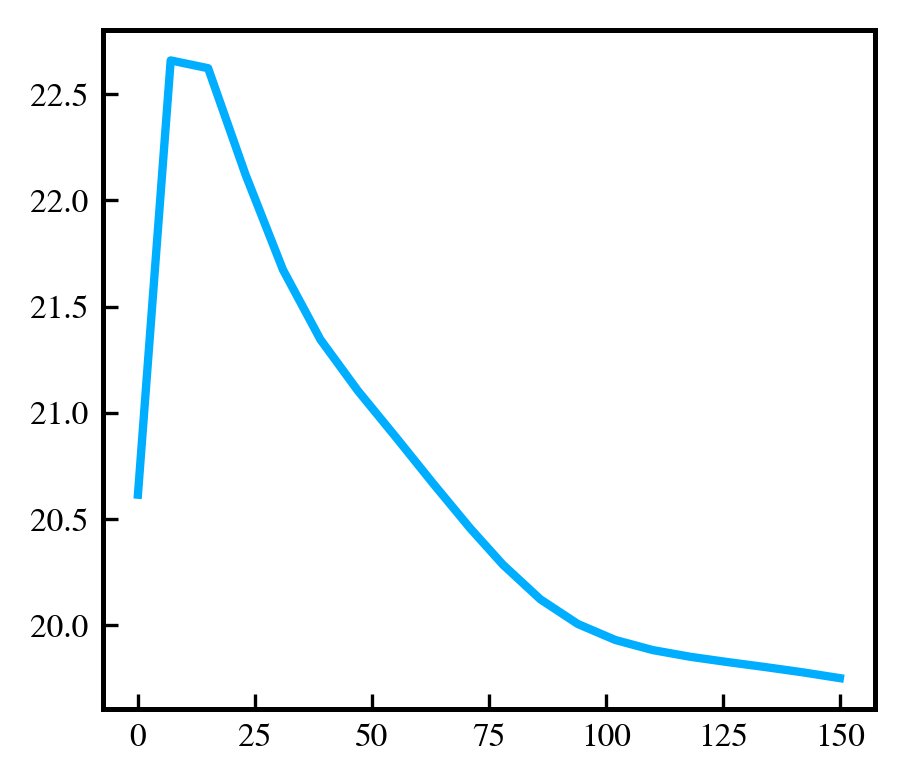

In [173]:
plt.plot(Hs,Ks)

<h3>scratch</h3>

In [ ]:
class signature_plot():
    def __init__(self):
        # Get df with deltalog returns
        self.length = 7650160#3
        self.__prep_df__(df_highres[:self.length])
        self.__obtain_RVs__()
        return
    
    def __prep_df__(self,df):
        df['LOGPRICE'] = np.log(df.PRICE)
        # Convert to returns
        df['DELTALOG'] = (df.LOGPRICE.diff()*100)
        # Only intraday, no interday returns since these screw up the results
        newday = pd.Series(df.index).diff()[pd.Series(df.index).diff()>pd.Timedelta('1h')].index
        df.loc[df.iloc[newday].index,'DELTALOG']=np.nan
        self.df = df[['DELTALOG']]
        
    def __worker__(self,dT):
        RVs = (self.df[:self.length].DELTALOG**2).resample(str(dT)+'ms').sum()
        RVOL = np.sqrt(np.median(RVs[RVs>0]))
        RVOL = RVOL * np.sqrt(252) * np.sqrt(6.5*3600*1000/dT)
        return RVOL
    
    def __obtain_RVs__(self):
        N = 60
        dT_array = np.logspace(2,6,N,dtype=int)
        RVOLs = Parallel(n_jobs=20)(delayed(self.__worker__)(dT) for dT in dT_array)
        self.dT = dT_array
        self.RVOLs = RVOLs
        
    def __plot__(self):
        plt.figure(figsize=(3.321,2.4))
        plt.scatter(self.dT/60000, self.RVOLs,color='black',s=2)
        plt.semilogx()
        plt.xlabel('Sampling frequency [minutes]')
        plt.ylabel('Annualized volatility [%]')
        plt.tight_layout()
        plt.savefig('signature_plot.pdf',bbox_inches='tight')
        plt.show()
        
sigplotter = signature_plot()
sigplotter.__plot__()

<ipython-input-8-9568d403e2c6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LOGPRICE'] = np.log(df.PRICE)
<ipython-input-8-9568d403e2c6>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DELTALOG'] = (df.LOGPRICE.diff()*100)
/home/luuk/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

In [ ]:
closingprices = df[['PRICE']].groupby(df.index.date).apply(lambda x: x.iloc[[-1]])
closingprices.index = closingprices.index.droplevel(0)
daily_returns = np.log(closingprices).diff().iloc[1:]

In [196]:
from scipy.optimize import minimize
class estimate_GARCH():
    def __init__(self,model,p,q):# or 'RealGARCH'
        self.options = {'eps':1e-09,
                      'disp': True,
                      'maxiter':2000}
        self.p,self.q = p,q
        self.model = model # 'RealGARCH'
        self.closingreturns = daily_returns.values.flatten()*100
        self.__RVOL__()
        # Call fit of GARCH
        self.fit_garch(self.closingreturns)
        return
    
    def __RVOL__(self):
        """Obtain realized volatilities from highfreq data"""
        # Convert to logprices
        df['LOGPRICE'] = np.log(df.PRICE)
        # Convert to returns
        df['DELTALOG'] = df.LOGPRICE.diff()*100
        # Only intraday, no interday returns since these screw up the results
        newday = pd.Series(df.index).diff()[pd.Series(df.index).diff()>pd.Timedelta('1h')].index
        df.loc[df.iloc[newday].index,'DELTALOG']=np.nan
        # Take sum of squared returns within one day and resample to annual volatility
        self.RVOL = np.sqrt((df[['DELTALOG']]**2).resample('1D').sum())
        self.RVOL = self.RVOL[self.RVOL>0]
        # Daily returns do not have first day and no weekends, so drop them
        self.RVOL = self.RVOL.dropna().values.flatten()[1:]
    
    def __llik_fun_GARCH__(self,params,estimate=True):
        x = self.closingreturns
        n = len(x)
        # Convert parameters back from their log normalization
        omega = np.exp(params[0])
        
        alphas = np.zeros(self.q)
        betas  = np.zeros(self.p)
        
        for i in range(0,self.q):
            alphas[i] = np.exp(params[i+1])/(1+np.exp(params[i+1]))
        for i in range(0,self.p):
            betas[i] = np.exp(params[i+self.q+1])/(1+np.exp(params[i+self.q+1]))
        
        # Iterate through sigma2 using the GARCH updating rules
        sigma2 = np.zeros(n)
        # fill first values with sample variance
        for i in range(0,max(self.p,self.q)+1):
            sigma2[i] = np.var(x)
        # Iterate through times
        for t in range(max(self.p,self.q),n):
            alpha_part = 0
            beta_part  = 0
            # Obtain beta part (lagged sigma2)
            for i in range(0,self.p):
                beta = betas[i]
                beta_part = beta_part+beta*sigma2[t-i-1]
            # Obtain alpha part (lagged returns)
            for i in range(0,self.q):
                alpha = alphas[i]
                
                if self.model == 'GARCH':
                    alpha_part = alpha_part+alpha*x[t-i-1]**2
                if self.model == 'RealGARCH':
                    alpha_part = alpha_part+alpha*self.RVOL[t-i-1]**2
            # Combine in sigma2[t]
            sigma2[t] = omega + alpha_part + beta_part
        
        # Derive likelihood
        if estimate:
            L = -0.5*np.log(2*np.pi) - 0.5*np.log(sigma2) - 0.5*x**2/sigma2

            llik = np.mean(L)

            return -1*llik
        else:
            return sigma2
    
    
    def fit_garch(self,x):
        # Initialize values
        b = np.ones(self.p)*(0.6/self.p)  # initial value for beta
        a = np.ones(self.q)*(0.2/self.q) # initial value for alpha
        omega = np.nanvar(self.closingreturns)*(1-np.sum(a)-np.sum(b)) # initial value for omega
        
        par_ini = np.array([omega])#np.array([np.log(omega)])
        
        alphas = np.zeros(self.q)
        betas  = np.zeros(self.p)
        
        for i in range(0,self.q):
            alphas[i] = np.log(a[i]/(1-a[i]))
        for i in range(0,self.p):
            betas[i] = np.log(b[i]/(1-b[i]))
        
        par_ini = np.hstack((par_ini,alphas, betas))
        
        est = minimize(self.__llik_fun_GARCH__, x0=par_ini,
                       options = self.options,
                       method = 'SLSQP',
                       #bounds = ((0.0001, 100), (0, 10), (0,1))
                      )
        llikhood = -est.fun
        self.AIC = 2*(len(par_ini))-2*llikhood
        self.BIC = (len(par_ini)) * np.log(len(self.closingreturns)) - 2*llikhood
        self.llik_opt = llikhood
        
        self.estimates = est.x
        omega_hat = np.exp(self.estimates[0])
        
        
        
        betas = np.array([np.exp(w)/(1+np.exp(w)) for w in self.estimates[1:self.p+1]])
        alphas = np.array([np.exp(w)/(1+np.exp(w)) for w in self.estimates[1+self.p:]])
        
        self.thetahat = np.hstack((omega_hat,alphas,betas))
        
        
    def return_vola(self):
        sigma2 = self.__llik_fun_GARCH__(self.estimates,estimate=False)
        return daily_returns.index,np.sqrt(sigma2)*np.sqrt(252)
    
    def return_llik_AIC_BIC(self):
        return self.AIC,self.BIC,self.llik_opt
    
    def predict_one_step(self):
        # The input to our prediction is the returns until time t
        # We thus estimate our GARCH model with this data
        # We want to estimate the volatility at time t+1
        # We thus predict the volatility at the next timestep using the estimated GARCH
        training_data = pd.concat([daily_returns.loc[year] for year in ['2015','2016','2017','2018']])
        
        # Fit the GARCH model using the first four years of data
        self.closingreturns = training_data.values.flatten()*100
        
        if self.model=='RealGARCH':
            # If we want the RealGARCH model, obtain realized volatilities
            self.__RVOL__()
        # Call fit of GARCH
        self.fit_garch(self.closingreturns)
        
        # Now we have fitted the GARCH model. We try to predict 
        testingdata = pd.concat([daily_returns.loc[year] for year in ['2019','2020']])
        self.closingreturns = testingdata.values.flatten()*100
        sigma2 = self.__llik_fun_GARCH__(self.estimates,estimate=False)
        return testingdata.index,np.sqrt(sigma2)*np.sqrt(252)
        
        
        

GARCH = estimate_GARCH(model='GARCH',p=2,q=2)
GARCH_time, GARCH_vola = GARCH.return_vola()
GARCH = estimate_GARCH(model='RealGARCH',p=2,q=2)
RealGARCH_time, RealGARCH_vola = GARCH.return_vola()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.8315938436887604
            Iterations: 27
            Function evaluations: 189
            Gradient evaluations: 27
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.7697830070157494
            Iterations: 22
            Function evaluations: 155
            Gradient evaluations: 22


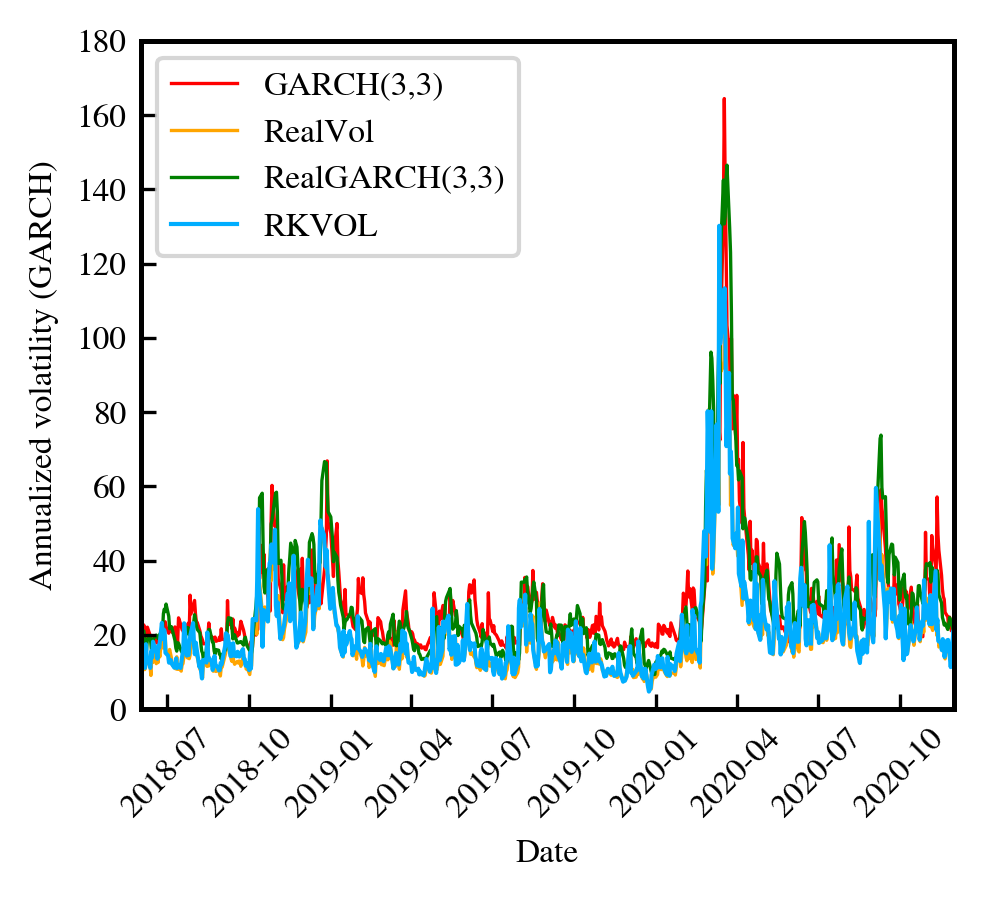

In [158]:
def plot_GARCHestimates():
    
    fig,ax=plt.subplots()
    plt.plot(GARCH_time, GARCH_vola,label='GARCH(3,3)',lw=0.8,color='red')
    plt.plot(RealGARCH_time,GARCH.RVOL*np.sqrt(252),lw=0.8,label='RealVol',color='orange')
    plt.plot(RealGARCH_time, RealGARCH_vola,label='RealGARCH(3,3)',lw=0.8,color='green')
    plt.xlim([datetime.date(2018, 6, 1), datetime.date(2020, 12, 1)])
    plt.plot(RK_values.index,RK_values.RealizedKernel,lw=1,label='RKVOL')

    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel('Annualized volatility (GARCH)')
    plt.legend(frameon=True)
    plt.tight_layout()
    plt.ylim(0,180)
    plt.savefig('Garch_RealGARCH_RVOL.pdf',bbox_inches='tight')
    plt.show()
plot_GARCHestimates()

In [206]:
from scipy.optimize import minimize
from scipy.special import gamma, factorial
class estimate_GAS():
    def __init__(self,model,p,q):# or 'RealGARCH'
        self.options = {'eps':1e-09,
                      'disp': True,
                      'maxiter':200}
        self.p, self.q = p, q
        self.nu = self.p + self.q + 1 # dof for t-distribution
        self.model = model # 'RealGARCH'
        self.closingreturns = daily_returns.values.flatten()*100
        if self.model=='RealGARCH':
            # If we want the RealGARCH model, obtain realized volatilities
            self.__RVOL__()
        # Call fit of GARCH
        self.fit_gas(self.closingreturns)
        return
    
    
    def nabla(self,lagged_obs,lagged_latent):
        ht = np.exp(lagged_latent)
        # Normal distribution
        if self.model == 'GARCH':
            return -1*np.pi + lagged_obs**2/(4*ht)
        # t-distribution density
        if self.model == 't-GAS':
            c = -0.5*((self.nu-2)*np.pi)
            a1 = ((self.nu+1)/2)*(1/(1+(lagged_obs**2)/((self.nu-2)*ht)))
            a2 = lagged_obs**2/((self.nu-2)*ht)
            return c + a1*a2
        # Poisson model
#         return (lagged_obs**2/np.exp(lagged_latent) -1 )
#         return (1/fisher)*gradient
        
        
    def __llik_fun_GAS__(self,params,estimate=True):
        x = self.closingreturns
        n = len(x)
        # Convert parameters back from their log normalization
        mu = np.exp(params[0])
        
        phis    = np.zeros(self.p)
        alphas  = np.zeros(self.q)
        
        for i in range(0,self.p):
            phis[i] = np.exp(params[i+1])/(1+np.exp(params[i+1]))
        for i in range(0,self.q):
            alphas[i] = np.exp(params[i+self.p+1])/(1+np.exp(params[i+self.p+1]))
        
        # Iterate through sigma2 using the GARCH updating rules
        ft = np.zeros(n)
        # fill first values with sample variance
        for i in range(0,max(self.p,self.q)+1):
            ft[i] = np.log(np.var(x))
        # Iterate through times
        for t in range(max(self.p,self.q),n):
            phi_part = 0
            alpha_part  = 0
            # Obtain beta part (lagged sigma2)
            for i in range(0,self.p):
                phi = phis[i]
                phi_part = phi_part+phi*ft[t-i-1]
            # Obtain alpha part (lagged returns)
            for i in range(0,self.q):
                alpha = alphas[i]
                alpha_part = alpha_part+alpha*self.nabla(x[t-i-1],ft[t-i-1])
            # Combine in sigma2[t]
            ft[t] = mu + phi_part + alpha_part
        sigma2 = np.exp(ft)
#         sigma2 = ft
        # Derive likelihood
        if estimate:
            # normal
            if self.model == 'GARCH':
                L = -0.5*np.log(2*np.pi) - 0.5*np.log(sigma2) - 0.5*x**2/sigma2
            # t-distribution
            elif self.model == 't-GAS':
                L = np.log(gamma((self.nu+1)/2)) - np.log(gamma(self.nu/2)) - 0.5*np.log((self.nu-2)*np.pi*sigma2) 
                - ((self.nu+1)/2)*np.log(1+((x**2)/((self.nu-2)*sigma2)))
            llik = np.mean(L)

            return -1*llik
        else:
            return sigma2
    
    
    def fit_gas(self,x):
        # Initialize values
        phis   = np.ones(self.p)*(0.1/self.p)  # initial value for phi
        alphas = np.ones(self.q)*(0.1/self.q) # initial value for alpha
        mu     = np.nanvar(self.closingreturns)*(1-np.sum(phis)-np.sum(alphas)) # initial value for mu
        
        par_ini = np.array([np.log(mu)])#np.array([np.log(omega)])
        
        phis_transformed = np.zeros(self.p)
        alphas_transformed  = np.zeros(self.q)
        
        for i in range(0,self.p):
            phis_transformed[i] = np.log(phis[i]/(1-phis[i]))
        for i in range(0,self.q):
            alphas_transformed[i] = np.log(alphas[i]/(1-alphas[i]))
        
        
        par_ini = np.hstack((par_ini,phis_transformed, alphas_transformed))
        
        est = minimize(self.__llik_fun_GAS__, x0=par_ini,
                       options = self.options,
                       method = 'SLSQP',
                       #bounds = ((0.0001, 100), (1e-5, 10), (1e-5,1))
                      )
        self.estimates = est.x
        mu_hat = np.exp(self.estimates[0])
        
        phis   = np.array([np.exp(w)/(1+np.exp(w)) for w in self.estimates[1:self.p+1]])
        alphas = np.array([np.exp(w)/(1+np.exp(w)) for w in self.estimates[1+self.p:]])
        
        self.thetahat = np.hstack((mu_hat,phis,alphas))
        
        
    def plot_vola(self):
        sigma2 = self.__llik_fun_GAS__(self.estimates,estimate=False)
        return daily_returns.index,np.sqrt(sigma2)*np.sqrt(252)


#GAS = estimate_GAS(model='t-GAS',p=2,q=2)
#t_tGAS,tgas_vola = GAS.plot_vola()
GAS = estimate_GAS(model='GARCH',p=3,q=3)
t_GARCH,tGARCH_vola = GAS.plot_vola()

<ipython-input-206-c9da18b783bb>:21: RuntimeWarning: overflow encountered in exp
  ht = np.exp(lagged_latent)
<ipython-input-206-c9da18b783bb>:69: RuntimeWarning: overflow encountered in exp
  sigma2 = np.exp(ft)
<ipython-input-206-c9da18b783bb>:62: RuntimeWarning: overflow encountered in double_scalars
  phi_part = phi_part+phi*ft[t-i-1]


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.856308624011895
            Iterations: 73
            Function evaluations: 675
            Gradient evaluations: 73


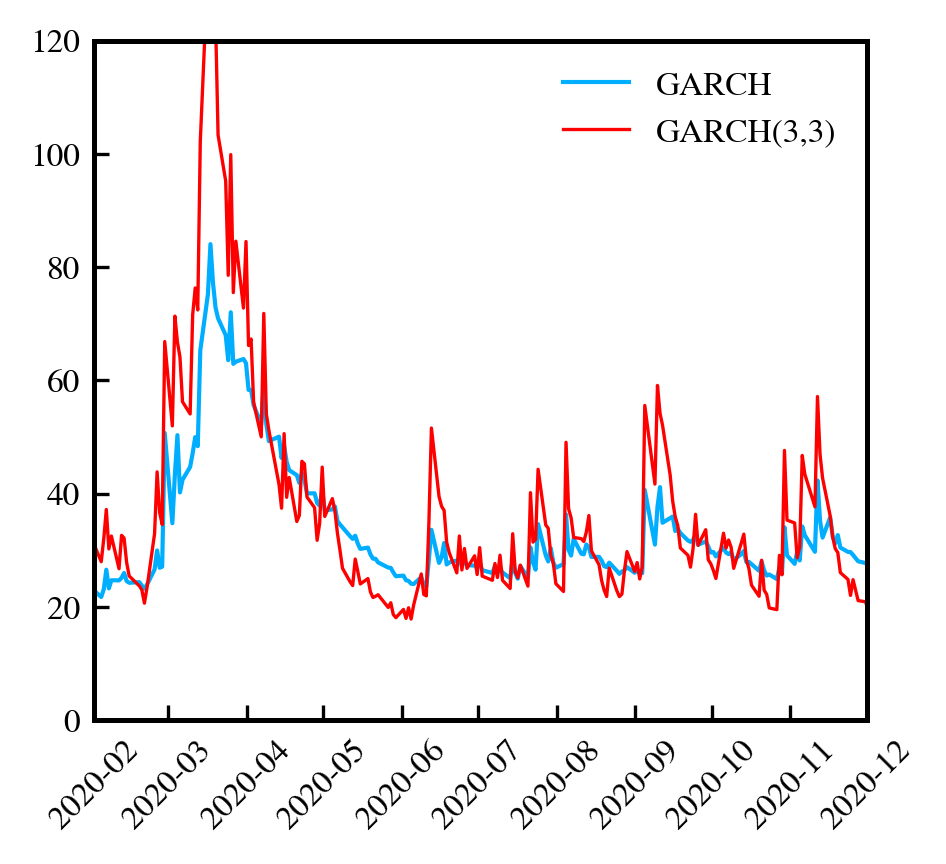

In [207]:
#plt.plot(t_tGAS[2:],tgas_vola[2:],lw=1, label='t-GAS')
plt.plot(t_GARCH[2:],tGARCH_vola[2:],lw=1, label='GARCH')
#plt.plot(t_GARCH,GARCH.RVOL*np.sqrt(252),label='RVOL',lw=1)
plt.xlim([datetime.date(2020, 2, 1), datetime.date(2020, 12, 1)])
plt.plot(GARCH_time, GARCH_vola,label='GARCH(3,3)',lw=0.8,color='red')
plt.xticks(rotation=45)
plt.ylim(0,120)
plt.legend()

In [ ]:
def get_qualities():
    df = pd.DataFrame({'Model':[],'p':[],'q':[],
                       'AIC':[],'BIC':[],'Log-Likelihood':[]})
    for p in np.arange(1,3,1,dtype=int):
        for q in np.arange(1,3,1,dtype=int):
            GARCH = estimate_GARCH(model='GARCH',p=p,q=q)
            AIC,BIC,L = GARCH.return_llik_AIC_BIC()
            df = df.append({'Model':'GARCH','p':p,'q':q,'AIC':AIC, 'BIC':BIC,'Log-Likelihood':L},ignore_index=True)
    for p in np.arange(1,3,1,dtype=int):
        for q in np.arange(1,3,1,dtype=int):
            GARCH = estimate_GARCH(model='RealGARCH',p=p,q=q)
            AIC,BIC,L = GARCH.return_llik_AIC_BIC()
            df = df.append({'Model':'RealGARCH','p':p,'q':q,'AIC':AIC, 'BIC':BIC,'Log-Likelihood':L},ignore_index=True)
    df = df.round(3)
    df['(p,q)'] = '('+df.p.astype(int).astype(str)+','+df.q.astype(int).astype(str)+')'
    df = df.set_index(['Model','(p,q)'])[['AIC','BIC','Log-Likelihood']]
    return df
#quality_df = get_qualities()

In [200]:
# Evaluate future predictions

In [246]:
def GARCH_predict(model):
    # Get future predictions
    times, volas = model.predict_one_step()
    times = np.array([w.strftime('%Y-%m-%d') for w in times])
    predictions = pd.DataFrame({'Day':times,'pred_vola':volas}).set_index('Day')

    truevol = pd.DataFrame(RVOL)
    truevol['day'] = np.array([w.strftime('%Y-%m-%d') for w in a.index])
    truevol = truevol.set_index('day')
    truevol = truevol[['return']]
    
    merged = pd.merge(predictions,truevol,left_index=True,right_index=True)
    
    MAE  = np.mean((merged.pred_vola - merged['return']).abs())
    RMSE = np.sqrt(np.mean((merged.pred_vola - merged['return'])**2))
    print('MAE',MAE,'   RMSE',RMSE)
    return MAE,RMSE
    
GARCH = estimate_GARCH(model='GARCH',p=2,q=2)
GARCH_predict(GARCH)

GARCH = estimate_GARCH(model='RealGARCH',p=2,q=2)
GARCH_predict(GARCH)


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.8315938436887604
            Iterations: 27
            Function evaluations: 189
            Gradient evaluations: 27
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.7857566843230608
            Iterations: 27
            Function evaluations: 189
            Gradient evaluations: 27
MAE 11.658151164613713    RMSE 13.811350786699224
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.7697830070157494
            Iterations: 22
            Function evaluations: 155
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.713898317658488
            Iterations: 24
            Function evaluations: 168
            Gradient evaluations: 24
MAE 11.71831516150037    RMSE 16.12524883638517


(11.71831516150037, 16.12524883638517)